In [2]:
!pip install gensim==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 53.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pickle
import pandas as pd
import nltk
import gensim

import numpy as np

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer

# Visualization & topic modelling
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install --user plotly
import plotly
import plotly.express as px

# utility modules
from ast import literal_eval

In [4]:
word_level_df = pd.read_csv('/work/GitHub_ML_Deepnote/Machine Learning/2. Cleaning & Pre-processing/word_level_df.csv', encoding='utf-8', index_col=0)
sentence_level_df = pd.read_csv('/work/GitHub_ML_Deepnote/Machine Learning/2. Cleaning & Pre-processing/sentence_level_df.csv',  encoding='utf-8', index_col = 0)

In [5]:
# Extract lemmas from the 'lemmas' column in word_level_df
corpus_words = [literal_eval(lemmas) for lemmas in word_level_df['lemmas'].values]

# Save corpus_words as a pickle file
with open('/work/GitHub_ML_Deepnote/Machine Learning/3. Word2vec /corpus_words.pkl', 'wb') as file:
    pickle.dump(corpus_words, file)

In [6]:
corpus_model = gensim.models.Word2Vec(corpus_words, min_count= 20, vector_size = 300)

In [7]:
corpus_model.wv['fear']

array([-0.0114778 ,  0.05796266, -0.02269808,  0.00965486, -0.01373911,
       -0.04997729,  0.05141878,  0.1163418 , -0.00885669, -0.03054929,
        0.0020776 , -0.01526112, -0.01490126, -0.03356866, -0.01386268,
       -0.05968718,  0.02847663,  0.00286328,  0.00753081, -0.02425808,
        0.00230078, -0.01649971,  0.06196782,  0.00743791, -0.00097281,
       -0.02389432, -0.07032242, -0.01632214, -0.05004275, -0.0434038 ,
        0.01223153, -0.03039546,  0.00416846, -0.00857056, -0.00803735,
        0.04635482,  0.01864874, -0.04656287, -0.0181047 ,  0.01049205,
       -0.00488778, -0.00739656,  0.00117902, -0.00500691,  0.01583084,
        0.0338657 , -0.00227123, -0.00764635, -0.00067755, -0.00666383,
        0.03217093,  0.00885422, -0.00060594,  0.02625534, -0.02197   ,
        0.07011892,  0.01669864,  0.01949963,  0.00063425,  0.00184836,
       -0.0243752 , -0.01188879, -0.00749765, -0.01928901, -0.00685233,
        0.03290421,  0.02877334,  0.01912286, -0.03637065, -0.02

In [8]:
#Creating a dataframe out of the corpus to train the model and it's relative word vectors.
corpus_vocab = corpus_model.wv.index_to_key
corpus_vectors = [corpus_model.wv[i] for i in corpus_vocab]
corpus_df = pd.DataFrame(corpus_vectors)

#Needed for principle component analysis 
corpus_df.columns = [str(i) for i in corpus_df.columns]


In [9]:
# Concatinating - reducing the dimensionality of the data into 3 components so we can plot it & visualise it. 

pca = PCA(n_components = 3)
comps_1 = pca.fit_transform(corpus_vectors)
pc_df_1 = pd.DataFrame(data = comps_1, columns = ['Principal Component '+str(i) for i in range(1, comps_1.shape[1]+1)])
corpus_df = pd.concat([corpus_df, pc_df_1], axis = 1)
corpus_df.index = corpus_vocab

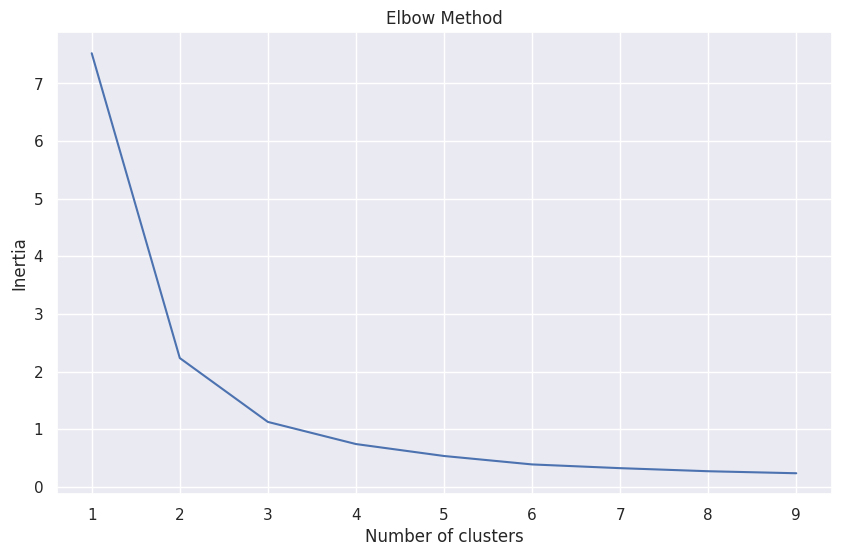

In [10]:
#Elbow method to identify number of clusters - this method indicates XXX as a good number.

#range being tested
inertia = []
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(corpus_vectors)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
# sns.lineplot(x=K, y=inertia, marker='o')
plt.plot(K,inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show() 

For n_clusters = 2 The average silhouette_score is : 0.656812481495502
For n_clusters = 3 The average silhouette_score is : 0.5440793906476584
For n_clusters = 4 The average silhouette_score is : 0.5093502603197383
For n_clusters = 5 The average silhouette_score is : 0.4625759882395192
For n_clusters = 6 The average silhouette_score is : 0.4693287804715866
For n_clusters = 7 The average silhouette_score is : 0.4567957330640317
For n_clusters = 8 The average silhouette_score is : 0.43120066661614875
For n_clusters = 9 The average silhouette_score is : 0.41816643117142466


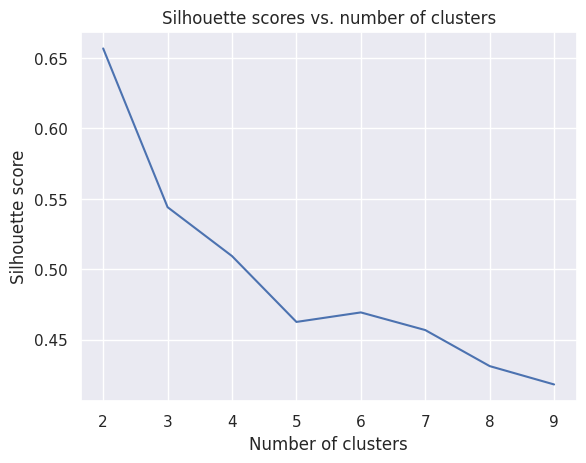

In [11]:
#Silhoutte method to identify optimal amount of clusters. This method is indicating 5.

#range of clusters to test
range_n_clusters = range(2, 10)

# Converting dataframe to numpy array for clustering
X = np.array(corpus_df)

# Initialising list to store silhouette scores for each number of clusters
silhouette_scores = []

# Iterating over set range of clusters and calculating silhouette score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init= 10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Plotting silhouette scores vs. number of clusters. A higher average silhouette score indicates better-defined clusters.
plt.plot(range_n_clusters, silhouette_scores)
plt.title("Silhouette scores vs. number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

In [12]:
# Clustering our data to see what groups together

kmeans = KMeans(n_clusters=3, random_state=0, n_init= 10 ).fit(corpus_df)

#Adding relevant values to our dataframe
corpus_df['clusters_knn'] = [str(i) for i in kmeans.labels_]

In [13]:
#Dimension reduction visualised and categorised into clusters

fig = px.scatter_3d(
    corpus_df, 
    x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
    color='clusters_knn',
    hover_data = [corpus_df.index]
    )

fig.update_traces(marker=dict(size = 5, line=dict(width=2,color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

pd.set_option('display.max_rows', None)

In [15]:
# Save the 3D scatter plot as an HTML file
fig.write_html('/work/GitHub_ML_Deepnote/Machine Learning/3. Word2vec /scatter_plot_3d.html')

### Using model (will be better once more data is added)

In [16]:
corpus_model.wv.most_similar(['future'])


[('would', 0.998334527015686),
 ('space', 0.9983179569244385),
 ('think', 0.998292088508606),
 ('consciousness', 0.9982757568359375),
 ('human', 0.9982631802558899),
 ('ai', 0.9982442855834961),
 ('get', 0.9982270002365112),
 ('say', 0.9981858134269714),
 ('like', 0.998163104057312),
 ('way', 0.998152494430542)]

In [17]:
corpus_model.wv.similarity("fear", "future")


0.9971076

In [18]:
corpus_model.wv.similarity("asi", "future")


0.9976518

In [19]:
corpus_model.wv.doesnt_match(['crisis',"fear", "asi", "good", "solution"])


'fear'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f64215d6-debc-46bd-b273-63565459a66d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>